In [2]:
import pandas as pd
import fastparquet


# Data Cleaning for our Forecasting #

Here we have just a datacleaning to have a table useful for our demand forecasts

In [ ]:
#This huge file is too large to update. See the readMe for instructions

dataM = pd.read_csv("Data/all_waybill_info_meituan_0322.csv")


In [4]:
dataM

,Unnamed: 0,dt,order_id,waybill_id,courier_id,da_id,is_courier_grabbed,is_weekend,estimate_arrived_time,is_prebook,...,recipient_lat,grab_lng,grab_lat,dispatch_time,grab_time,fetch_time,arrive_time,estimate_meal_prepare_time,order_push_time,platform_order_time
0,0,20221017,0,0,0,0,0,1,1665937978,0,...,45852786,0,0,1665936258,0,0,0,1665936779,1665936000,1665935996
1,1,20221017,1,1,1,1,1,1,1665937864,0,...,45898250,174530062,45906005,1665936734,1665936737,1665937344,1665937798,1665936845,1665936006,1665935995
2,2,20221017,2,2,2,2,1,0,1665939504,0,...,45891243,174548244,45870923,1665937484,1665937501,1665938346,1665939384,1665938007,1665937107,1665937097
3,3,20221017,3,3,3,0,1,0,1665939432,0,...,45886787,174560199,45867948,1665937394,1665937397,1665937830,1665939822,1665937634,1665937369,1665937028
4,4,20221017,4,4,4,0,1,0,1665938894,0,...,45867411,174554896,45865167,1665937394,1665937413,1665937710,1665938262,1665937694,1665937373,1665937092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654338,654338,20221024,57635,654338,1159,0,0,0,1666624606,0,...,45847351,0,0,1666623138,0,0,0,1666623458,1666622318,1666622098
654339,654339,20221024,568543,654339,1957,0,1,0,1666625239,0,...,45862730,174576809,45873238,1666623438,1666623463,1666624287,1666624689,1666624152,1666623436,1666623313
654340,654340,20221024,568544,654340,2323,9,1,0,1666627392,0,...,45873834,174624149,45872077,1666625247,1666625261,1666626227,1666627172,1666625534,1666625227,1666624923
654341,654341,20221024,162081,654341,211,12,1,0,1666628412,0,...,45887366,174537979,45895683,1666626827,1666626842,1666627538,1666628197,1666627153,1666626613,1666626599


In [ ]:
cleanedS1 = dataM[dataM["is_courier_grabbed"] == 1].reset_index(drop=True)
columns_to_keep = ["order_id", "da_id", "platform_order_time"]
cleanedS2 = cleanedS1[columns_to_keep]
cleanedS2['platform_order_time'] = pd.to_datetime(cleanedS2['platform_order_time'], unit='s') + pd.Timedelta(hours=8)

cleanedS3 = cleanedS2[cleanedS2['platform_order_time'] >= '2022-10-17']
cleanedS3['time_bin'] = cleanedS3['platform_order_time'].dt.floor('15T')


In [31]:
agg_df = cleanedS3.groupby(['time_bin', 'da_id']).size().reset_index(name='order_count')

In [32]:
agg_df.to_parquet("C:/Users/freud/Tensorflow/DataFrames/agg_table_old_zones.parquet", index=False)

In [12]:
dataNew = pd.read_parquet("C:/Users/freud/Tensorflow/DataFrames/new_zones8.parquet")


In [15]:
df_aggregate = dataNew[["order_id", "new_area_id", "hex_center_lat", "hex_center_lng"]]
# Aggregation nach h3_index: Zähle Bestellungen pro Zelle
aggregated = df_aggregate.groupby('new_area_id').agg(
    order_count=('order_id', 'count'),
    hex_center_lat=('hex_center_lat', 'min'),
    hex_center_lng=('hex_center_lng', 'max'),
).reset_index()
aggregated

,new_area_id,order_count,hex_center_lat,hex_center_lng
0,hexagon1,10268,45.906551,174.534859
1,hexagon10,5024,45.896910,174.591911
2,hexagon100,160,45.830819,174.590990
3,hexagon101,196,45.882679,174.505227
4,hexagon102,125,45.826686,174.525023
...,...,...,...,...
134,hexagon95,381,45.916647,174.555524
135,hexagon96,51,45.870292,174.518261
136,hexagon97,223,45.820723,174.570347
137,hexagon98,119,45.844130,174.522319


In [16]:
dataNew['platform_order_time'] = pd.to_datetime(dataNew['platform_order_time'], unit='s') + pd.Timedelta(hours=8)

In [17]:
dataNew = dataNew[dataNew['platform_order_time'] >= '2022-10-17']

In [18]:
dataNew['time_bin'] = dataNew['platform_order_time'].dt.floor('15T')

C:\Users\freud\AppData\Local\Temp\ipykernel_25716\2926614271.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  dataNew['time_bin'] = dataNew['platform_order_time'].dt.floor('15T')
C:\Users\freud\AppData\Local\Temp\ipykernel_25716\2926614271.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataNew['time_bin'] = dataNew['platform_order_time'].dt.floor('15T')


In [20]:
dataNew

,level_0,index,Unnamed: 0,dt,order_id,waybill_id,courier_id,da_id,is_courier_grabbed,is_weekend,...,estimate_meal_prepare_time,order_push_time,platform_order_time,latitude,longitude,h3_index,new_area_id,hex_center_lat,hex_center_lng,time_bin
1,1,2,2,20221017,2,2,2,2,1,0,...,1665938007,1665937107,2022-10-17 00:18:17,45.861460,174.532407,88329b5abbfffff,hexagon2,45.857903,174.531290,2022-10-17 00:15:00
2,2,3,3,20221017,3,3,3,0,1,0,...,1665937634,1665937369,2022-10-17 00:17:08,45.868015,174.559718,88329b5aa3fffff,hexagon3,45.864332,174.563614,2022-10-17 00:15:00
3,3,4,4,20221017,4,4,4,0,1,0,...,1665937694,1665937373,2022-10-17 00:18:12,45.868015,174.559718,88329b5aa3fffff,hexagon3,45.864332,174.563614,2022-10-17 00:15:00
4,4,5,5,20221017,5,5,5,3,1,0,...,1665939225,1665938403,2022-10-17 00:39:59,45.920329,174.542688,88329b58bdfffff,hexagon4,45.920317,174.543840,2022-10-17 00:30:00
5,5,6,6,20221017,6,6,6,2,1,0,...,1665942172,1665941872,2022-10-17 01:32:46,45.865154,174.557054,88329b5ab5fffff,hexagon5,45.868004,174.551940,2022-10-17 01:30:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498850,568541,654337,654337,20221024,568542,654337,1852,9,1,0,...,1666623812,1666622612,2022-10-24 22:39:50,45.879427,174.650494,88329b5863fffff,hexagon11,45.878522,174.650278,2022-10-24 22:30:00
498851,568542,654339,654339,20221024,568543,654339,1957,0,1,0,...,1666624152,1666623436,2022-10-24 22:55:13,45.868634,174.575022,88329b5aa7fffff,hexagon47,45.869380,174.573941,2022-10-24 22:45:00
498852,568543,654340,654340,20221024,568544,654340,2323,9,1,0,...,1666625534,1666625227,2022-10-24 23:22:03,45.879398,174.650478,88329b5863fffff,hexagon11,45.878522,174.650278,2022-10-24 23:15:00
498853,568544,654341,654341,20221024,162081,654341,211,12,1,0,...,1666627153,1666626613,2022-10-24 23:49:59,45.889549,174.535543,88329b58d5fffff,hexagon44,45.889114,174.537562,2022-10-24 23:45:00


In [21]:
#Here we aggregate the Orders per hexagon per time bin of 15 Minutes

agg_new = dataNew.groupby(['time_bin', 'h3_index']).size().reset_index(name='order_count')

In [22]:
#Save it for Prediction Models

agg_new.to_parquet("C:/Users/freud/Tensorflow/DataFrames/agg_table_new_zones8Bot.parquet",index=False)

### Creating area meta data for plotting ###

In [34]:
area_metadata = dataNew.groupby('adjusted_area_id').agg(
    hex_center_lat=('hex_center_lat', 'mean'),  # alternativ: 'first' oder 'min'
    hex_center_lng=('hex_center_lng', 'mean'),
    h3_index=('h3_index', 'first')  # falls eindeutig
).reset_index()


In [35]:
area_metadata

,adjusted_area_id,hex_center_lat,hex_center_lng,h3_index
0,hexagon1,45.902881,174.546541,87329b588ffffff
1,hexagon10,45.881772,174.560919,87329b58cffffff
2,hexagon11,45.877212,174.628329,87329b580ffffff
3,hexagon12,45.759683,174.579794,87329b514ffffff
4,hexagon13,45.904856,174.512523,87329b589ffffff
5,hexagon15,45.844196,174.521345,87329b5a9ffffff
6,hexagon16,45.820723,174.570347,87329b5acffffff
7,hexagon17,45.839483,174.589687,87329b5aeffffff
8,hexagon18,45.883103,174.526180,87329b58dffffff
9,hexagon19,45.777912,174.562481,87329b510ffffff


In [36]:
area_metadata.to_parquet("C:/Users/freud/Tensorflow/DataFrames/area_metadata_zones7Bot.parquet", index=False)

### Creation of Neighbours ###

In [5]:
import h3
import pandas as pd
neighbourZones = pd.read_parquet("C:/Users/freud/Tensorflow/DataFrames/new_zones8.parquet")


In [6]:
neighbourZones

,level_0,index,Unnamed: 0,dt,order_id,waybill_id,courier_id,da_id,is_courier_grabbed,is_weekend,...,arrive_time,estimate_meal_prepare_time,order_push_time,platform_order_time,latitude,longitude,h3_index,new_area_id,hex_center_lat,hex_center_lng
0,0,1,1,20221017,1,1,1,1,1,1,...,1665937798,1665936845,1665936006,1665935995,45.905850,174.529930,88329b5883fffff,hexagon1,45.906551,174.534859
1,1,2,2,20221017,2,2,2,2,1,0,...,1665939384,1665938007,1665937107,1665937097,45.861460,174.532407,88329b5abbfffff,hexagon2,45.857903,174.531290
2,2,3,3,20221017,3,3,3,0,1,0,...,1665939822,1665937634,1665937369,1665937028,45.868015,174.559718,88329b5aa3fffff,hexagon3,45.864332,174.563614
3,3,4,4,20221017,4,4,4,0,1,0,...,1665938262,1665937694,1665937373,1665937092,45.868015,174.559718,88329b5aa3fffff,hexagon3,45.864332,174.563614
4,4,5,5,20221017,5,5,5,3,1,0,...,1665940496,1665939225,1665938403,1665938399,45.920329,174.542688,88329b58bdfffff,hexagon4,45.920317,174.543840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498850,568541,654337,654337,20221024,568542,654337,1852,9,1,0,...,1666623914,1666623812,1666622612,1666622390,45.879427,174.650494,88329b5863fffff,hexagon11,45.878522,174.650278
498851,568542,654339,654339,20221024,568543,654339,1957,0,1,0,...,1666624689,1666624152,1666623436,1666623313,45.868634,174.575022,88329b5aa7fffff,hexagon47,45.869380,174.573941
498852,568543,654340,654340,20221024,568544,654340,2323,9,1,0,...,1666627172,1666625534,1666625227,1666624923,45.879398,174.650478,88329b5863fffff,hexagon11,45.878522,174.650278
498853,568544,654341,654341,20221024,162081,654341,211,12,1,0,...,1666628197,1666627153,1666626613,1666626599,45.889549,174.535543,88329b58d5fffff,hexagon44,45.889114,174.537562


In [ ]:
# Mapping of h3_index → adjusted_area_id
# h3_to_area = dict(zip(neighbourZones['h3_index'], neighbourZones['new_area_id']))

In [8]:
# Nur Zellen, die in deiner Tabelle vorkommen (du hast ja nur für diese Daten)
valid_h3_indexes = set(neighbourZones['h3_index'])

In [16]:
adjacency_dict = {}

# for row in neighbourZones.itertuples():
#     h3_id = row.h3_index
#     area_id = row.new_area_id
    
#     # Hole Nachbarzellen (direkte Nachbarschaft)
#     neighbors = h3.grid_ring(h3_id, 1)
#     valid_neighbors = [h3_to_area[n] for n in neighbors if n in valid_h3_indexes]
    
#     adjacency_dict[area_id] = valid_neighbors

for h3_id in valid_h3_indexes:
    # Hole Nachbarzellen (direkte Nachbarschaft)
    neighbors = h3.grid_ring(h3_id, 1)
    valid_neighbors = [n for n in neighbors if n in valid_h3_indexes]
    
    adjacency_dict[h3_id] = valid_neighbors

In [17]:
import numpy as np

h3_ids = list(adjacency_dict.keys())
index_map = {area: i for i, area in enumerate(h3_ids)}
n = len(h3_ids)
adj_matrix = np.zeros((n, n))

for source, neighbors in adjacency_dict.items():
    i = index_map[source]
    for target in neighbors:
        j = index_map[target]
        adj_matrix[i, j] = 1  # Oder 0.5 für symmetrische Nachbarschaft


In [18]:
adj_df = pd.DataFrame(adj_matrix, index=h3_ids, columns=h3_ids)


In [19]:
adj_df

,88329b4325fffff,88329b5abbfffff,88329b5147fffff,88329b514bfffff,88329b4361fffff,88329b5815fffff,88329b5853fffff,88329b5835fffff,88329b58e3fffff,88329b58b9fffff,...,88329b58d3fffff,88329b5831fffff,88329b58d9fffff,88329b5a93fffff,88329b5811fffff,88329b58b3fffff,88329b5817fffff,88329b5813fffff,88329b5aa9fffff,88329b5895fffff
88329b4325fffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88329b5abbfffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88329b5147fffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88329b514bfffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88329b4361fffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88329b58b3fffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88329b5817fffff,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
88329b5813fffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
88329b5aa9fffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
adj_df.to_parquet("C:/Users/freud/Tensorflow/DataFrames/neighbours_zones_8.parquet",index=False)

In [21]:
adj_df.sum(axis=1).sort_values(ascending=False)


88329b5ae3fffff    6.0
88329b5aa5fffff    6.0
88329b5aadfffff    6.0
88329b58c3fffff    6.0
88329b5a8dfffff    6.0
                  ... 
88329b59d7fffff    1.0
88329b5835fffff    1.0
88329b514bfffff    1.0
88329b4343fffff    0.0
88329b5a15fffff    0.0
Length: 139, dtype: float64

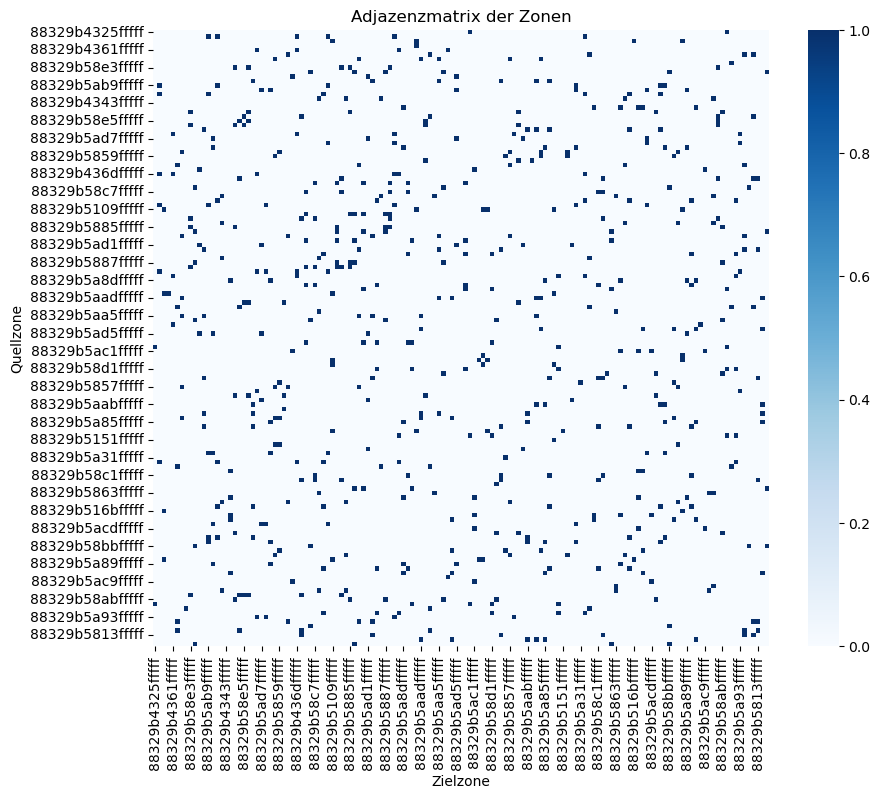

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(adj_df, cmap="Blues", square=True)
plt.title("Adjazenzmatrix der Zonen")
plt.xlabel("Zielzone")
plt.ylabel("Quellzone")
plt.show()


In [47]:
edges = []

for source, neighbors in adjacency_dict.items():
    for target in neighbors:
        edges.append((source, target))  # gerichtete Kante

edges_df = pd.DataFrame(edges, columns=["source", "target"])


In [48]:
edges_df

,source,target
0,hexagon1,hexagon10
1,hexagon1,hexagon6
2,hexagon1,hexagon21
3,hexagon1,hexagon4
4,hexagon1,hexagon13
...,...,...
73,hexagon9,hexagon8
74,hexagon9,hexagon11
75,hexagon9,hexagon6
76,hexagon9,hexagon10
